# PE Resolution Classification

We perform a univariable classifications using each explanatory variable. We then perform multivariable classifications. For these, we focus on body composition only, cardiopulmonary features only, and then a composite model. For each of these, we perform three forms of feature selection, using (1) recursive feature elimination with cross validation, (2) forward sequential feature selection with cross validation, and (3) backward feature selection with cross validation. For these groups of selected features, we also perform sensitivities controlling for gender, age, and both gender and age.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm.notebook import trange, tqdm
from config import model_config

from scipy.stats import shapiro
from sklearn.ensemble import (
	RandomForestClassifier
)
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
    LogisticRegressionCV
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
	roc_curve, roc_auc_score, auc, RocCurveDisplay
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score, cross_val_predict, KFold, StratifiedKFold,
    RepeatedStratifiedKFold
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer,
)
import statsmodels.api as sm
from xgboost import XGBClassifier

from regression import reg

In [107]:
SEED = 123
TEST_SIZE = 0.25
CV_FOLDS = 5
CUSTOM_CV = RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=25, random_state=SEED)

HEATMAP_COLORS = sns.diverging_palette(h_neg=359, h_pos=250, as_cmap=True)
plt.style.use('ggplot')

USE_INITIAL = True
USE_CLUSTERED_SE = False

# Import Data

In [108]:
if USE_INITIAL:
    with open(Path('../data/classification_data_initial.pkl'), 'rb') as f:
    	data = pickle.load(f)
else:
    with open(Path('../data/classification_data_all.pkl'), 'rb') as f:
    	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y').squeeze()
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')
control_features = data.get('controls')
clot_features = data.get('clot_features')
all_features = body_features + cardio_features + control_features + clot_features

print(X.shape)
print(y.shape)
print(body_features)
print(cardio_features)
print(control_features)
print(clot_features)

(44, 43)
(44,)
['volume_visceral_fat', 'density_visceral_fat', 'mass_visceral_fat', 'volume_subcutaneous_fat', 'density_subcutaneous_fat', 'mass_subcutaneous_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'mass_intermuscular_fat', 'volume_muscle', 'density_muscle', 'mass_muscle', 'volume_bone', 'density_bone', 'mass_bone', 'bmi', 'bsa']
['emphysema_volume_950hu', 'lung_volume', 'extrapulmonary_artery_volume', 'extrapulmonary_vein_volume', 'intrapulmonary_artery_volume', 'intrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5', 'bv10', 'pb_larger_10', 'pv_diameter', 'a_diameter', 'pv_a', 'heart_volume', 'airway_volume', 'airway_ratio', 'ild_volume', 'ild_ratio']
['age', 'gender_cl_Male']
['superior_right', 'superior_left', 'middle_right', 'inferior_right', 'inferior_left', 'centralartery']


In [109]:
pe_numbers = y.index.str[:-2]
print(len(pe_numbers))
pe_numbers

44


Index(['PE1', 'PE12', 'PE14', 'PE15', 'PE16', 'PE17', 'PE18', 'PE19', 'PE2',
       'PE20', 'PE21', 'PE22', 'PE23', 'PE24', 'PE25', 'PE27', 'PE28', 'PE3',
       'PE31', 'PE32', 'PE33', 'PE34', 'PE36', 'PE37', 'PE4', 'PE40', 'PE41',
       'PE42', 'PE43', 'PE44', 'PE45', 'PE47', 'PE48', 'PE49', 'PE5', 'PE51',
       'PE52', 'PE53', 'PE54', 'PE56', 'PE6', 'PE7', 'PE8', 'PE9'],
      dtype='object')

In [110]:
y.head(2)

PE1_0     1
PE12_0    0
Name: resolved_pe, dtype: int64

In [111]:
y.value_counts(dropna=False)

0    28
1    16
Name: resolved_pe, dtype: int64

In [112]:
X[clot_features].head()

,superior_right,superior_left,middle_right,inferior_right,inferior_left,centralartery
PE1_0,2.670711,0.628977,2.792118,0.529711,0.437219,1.364471
PE12_0,-0.087756,-0.540032,0.843203,-0.485265,-0.486582,-0.608313
PE14_0,-0.622289,-0.504241,-0.613080,-0.515404,0.097693,-0.440493
PE15_0,-0.770509,-0.540032,-0.599869,-0.510198,-0.559002,-0.608154
PE16_0,0.708296,6.602565,0.873221,0.161220,1.380275,1.215378


# Logit Regression Functions

In [113]:
def get_sorted_params(fitted_model):
    """Returns pd.Series of coefs for comparison with statsmodels params."""
    coef = pd.Series(
        np.array(fitted_model.coef_).flatten(), 
        index=np.array(fitted_model.feature_names_in_).flatten()
    )
    # print(fitted_model.get_params().get('fit_intercept'))
    if fitted_model.get_params().get('fit_intercept'):
        coef['const'] = fitted_model.intercept_[0]
        
    return coef.sort_index()

In [114]:
def check_params_equal(model_sm, model_sk):
    """Checks whether the coefficients from an sklearn and statsmodel regression are the same"""
    sorted_params = get_sorted_params(model_sk)
    coefs_are_equal = np.all(np.isclose(sorted_params, model_sm.params.sort_index(), atol=1e-04))
    return coefs_are_equal

In [115]:
def model_residual_correlation(model):
    """Returns measure of correlation."""
    return np.corrcoef(np.arange(len(model.resid)), model.resid)[1, 0]

In [116]:
def fit_model(X, y):
    """Fit statsmodels OLS model with robust SEs and sklearn OLS model."""
    
    # Fit statsmodels
    model_sm = sm.GLM(y, sm.add_constant(X), family=sm.families.Binomial())
    if USE_CLUSTERED_SE:
        model_sm = model_sm.fit(cov_type='cluster', cov_kwds={'groups': pe_numbers})
    else: 
        model_sm = model_sm.fit(cov_type='HC3')

    # Fit sklearn 
    model_sk = LogisticRegression(
        random_state=SEED,
        fit_intercept=True,
        max_iter=5_000, 
        penalty=None, 
        solver='lbfgs',
    )
    model_sk.fit(X, y)

    # Check coefs equal
    params_are_equal = check_params_equal(model_sm, model_sk)
    if not params_are_equal:
        print("\nModels did not have same coefs")
        print(get_sorted_params(model_sk))
        print(model_sm.params.sort_index())
        print("---------------------------------")
    return model_sm, model_sk

In [117]:
def store_model_results(model_sm, model_sk, X, y):
    """
    Params:
        - model_sm: statsmodel model for coefs, pvalues, and residuals.
        - model_sk: sklearn model for cross validation
        - X: X data.
        - y: y data.
    """
    # Calculate CV scores
    cv_scores = cross_val_score(
        model_sk, X, y, 
        scoring='roc_auc', 
        cv=CUSTOM_CV, n_jobs=-1
    )
    # Store model results
    model_results = pd.DataFrame(
        {
            'y': y.name,
            'model_dfn': [('const',) + tuple(X.columns.values)],
            'nobs': model_sm.nobs,
            'shapiro_resid_pvalue': np.nan,
            'metric_train': model_sk.score(X, y),
            'metric_cv_mean': np.mean(cv_scores),
            'metric_cv_std': np.std(cv_scores),
        }
    )
    # Set model index
    model_results = model_results.set_index(['y', 'model_dfn'])
    return model_results

In [118]:
def store_coef_results(model_sm, y):
    """
    Params:
        - model_sm: statsmodel model for coefs, pvalues, and residuals.
        - y: y data.
    """
    results = pd.DataFrame(
        {
            'model_dfn': [tuple(model_sm.params.index) for _ in range(len(model_sm.params))],
            'coef': model_sm.params, 
            'pval': model_sm.pvalues,
        },
    )
    results['signif'] = results['pval'].apply(reg.add_significance)
    results = results.reset_index(names='x')
    results['y'] = y.name
    results = results.pivot(index=['y', 'model_dfn'], columns=['x'], values=['coef', 'pval', 'signif'])
    results.columns = ['_'.join(idx) for idx in results.columns]
    return results

In [119]:
def combine_model_results(model_sm, model_sk, X, y):
    model_results = store_model_results(model_sm, model_sk, X, y)
    coef_results = store_coef_results(model_sm, y)
    assert model_results.shape[0] == coef_results.shape[0] 
    combined_results = pd.concat([model_results, coef_results], axis=1)
    return combined_results

## Example

In [120]:
target = 'resolved_pe'
features = ['pv_a', 'density_bone']
X_temp = X[features]
y_temp = y.copy()
model_sm, model_sk = fit_model(X_temp, y_temp)
combine_model_results(model_sm, model_sk, X_temp, y_temp)

,,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_const,coef_density_bone,coef_pv_a,pval_const,pval_density_bone,pval_pv_a,signif_const,signif_density_bone,signif_pv_a
y,model_dfn,,,,,,,,,,,,,,
resolved_pe,"(const, pv_a, density_bone)",44,NaN,0.681818,0.610933,0.197955,-0.652616,-0.643259,-0.130821,0.064015,0.029889,0.701322,,*,


# Perform univariable regressions 

In [121]:
univariable_results = pd.DataFrame()

for feature in tqdm(all_features):

    X_temp = X[[feature]]
    y_temp = y.copy()
    model_sm, model_sk = fit_model(X_temp, y_temp)

    univariable_results = pd.concat(
        [univariable_results, combine_model_results(model_sm, model_sk, X_temp, y_temp)],
        axis=0
    )

print(univariable_results.shape)

univariable_results.head()

  0%|          | 0/43 [00:00<?, ?it/s]

(43, 137)


nobs  shapiro_resid_pvalue  \
y           model_dfn                                                       
resolved_pe (const, volume_visceral_fat)         44                   NaN   
            (const, density_visceral_fat)        44                   NaN   
            (const, mass_visceral_fat)           44                   NaN   
            (const, volume_subcutaneous_fat)     44                   NaN   
            (const, density_subcutaneous_fat)    44                   NaN   

                                               metric_train  metric_cv_mean  \
y           model_dfn                                                         
resolved_pe (const, volume_visceral_fat)           0.613636        0.509422   
            (const, density_visceral_fat)          0.636364        0.664511   
            (const, mass_visceral_fat)             0.613636        0.509422   
            (const, volume_subcutaneous_fat)       0.636364        0.373067   
            (const, density_subcutaneous_fat)      0.636364        0.419622   

                                               metric_cv_std coef_const  \
y           model_dfn                                                     
resolved_pe (const, volume_visceral_fat)            0.216260  -0.582495   
            (const, density_visceral_fat)           0.158150  -0.676904   
            (const, mass_visceral_fat)              0.216260  -0.582498   
            (const, volume_subcutaneous_fat)        0.169671  -0.561734   
            (const, density_subcutaneous_fat)       0.165255  -0.563769   

                                              coef_volume_visceral_fat  \
y           model_dfn                                                    
resolved_pe (const, volume_visceral_fat)                      0.125076   
            (const, density_visceral_fat)                          NaN   
            (const, mass_visceral_fat)                             NaN   
            (const, volume_subcutaneous_fat)                       NaN   
            (const, density_subcutaneous_fat)                      NaN   

                                              pval_const  \
y           model_dfn                                      
resolved_pe (const, volume_visceral_fat)        0.063812   
            (const, density_visceral_fat)       0.036075   
            (const, mass_visceral_fat)          0.063805   
            (const, volume_subcutaneous_fat)    0.073363   
            (const, density_subcutaneous_fat)   0.072595   

                                              pval_volume_visceral_fat  \
y           model_dfn                                                    
resolved_pe (const, volume_visceral_fat)                      0.637687   
            (const, density_visceral_fat)                          NaN   
            (const, mass_visceral_fat)                             NaN   
            (const, volume_subcutaneous_fat)                       NaN   
            (const, density_subcutaneous_fat)                      NaN   

                                              signif_const  ...  \
y           model_dfn                                       ...   
resolved_pe (const, volume_visceral_fat)                    ...   
            (const, density_visceral_fat)                *  ...   
            (const, mass_visceral_fat)                      ...   
            (const, volume_subcutaneous_fat)                ...   
            (const, density_subcutaneous_fat)               ...   

                                              signif_middle_right  \
y           model_dfn                                               
resolved_pe (const, volume_visceral_fat)                      NaN   
            (const, density_visceral_fat)                     NaN   
            (const, mass_visceral_fat)                        NaN   
            (const, volume_subcutaneous_fat)                  NaN   
            (const, density_subcutaneous_fat)                 NaN   

              

In [122]:
univariable_results = univariable_results.reset_index()
univariable_results['selection_method'] = 'All'
univariable_results['model_dfn'] = univariable_results['model_dfn'].apply(lambda x: x[1])
univariable_results['category'] = 'univariable_' + univariable_results['model_dfn']
univariable_results['controls'] = 'None'
univariable_results.index = univariable_results[['category', 'selection_method', 'y', 'controls']].apply('%'.join, axis=1)
univariable_results.index.name = 'Lookup'
print(univariable_results.shape)
univariable_results.tail()

(43, 142)


,y,model_dfn,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_const,coef_volume_visceral_fat,pval_const,...,signif_inferior_right,coef_inferior_left,pval_inferior_left,signif_inferior_left,coef_centralartery,pval_centralartery,signif_centralartery,selection_method,category,controls
Lookup,,,,,,,,,,,,,,,,,,,,,
univariable_superior_left%All%resolved_pe%None,resolved_pe,superior_left,44,NaN,0.636364,0.508400,0.189412,-0.499125,NaN,0.120592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_superior_left,None
univariable_middle_right%All%resolved_pe%None,resolved_pe,middle_right,44,NaN,0.636364,0.398600,0.170292,-0.541939,NaN,0.086019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_middle_right,None
univariable_inferior_right%All%resolved_pe%None,resolved_pe,inferior_right,44,NaN,0.636364,0.597489,0.231927,-0.656995,NaN,0.043256,...,,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_inferior_right,None
univariable_inferior_left%All%resolved_pe%None,resolved_pe,inferior_left,44,NaN,0.636364,0.464956,0.223791,-0.591847,NaN,0.064431,...,NaN,0.15598,0.586598,,NaN,NaN,NaN,All,univariable_inferior_left,None
univariable_centralartery%All%resolved_pe%None,resolved_pe,centralartery,44,NaN,0.636364,0.436644,0.194314,-0.502788,NaN,0.123818,...,NaN,NaN,NaN,NaN,-0.152514,0.538614,,All,univariable_centralartery,None


# Perform multivariable regressions

## Feature selection

### Lasso Regularization

In [123]:
model_dfns = [control_features, body_features, cardio_features, clot_features, all_features]
model_dfn_names = ['demo', 'body', 'cardio', 'clot', 'all']
model_dfns_remaining = list()

y_temp = y.copy()


multivariable_results = pd.DataFrame()
for i, feats in enumerate(model_dfns):

    low_Cs = -4
    high_Cs = -0.5

    logitCV = LogisticRegressionCV(
        Cs=np.logspace(low_Cs, high_Cs, 50), 
        cv=CUSTOM_CV, 
        penalty='l1', 
        solver='liblinear', 
        max_iter=5_000, 
        scoring='roc_auc',
        fit_intercept=True,
        random_state=SEED,
        n_jobs=-1
    )
        
    # Select features
    X_init = X[feats]
    returns_null_set = True
    while returns_null_set:
        logitCV.fit(X_init, y_temp)
        coefs = pd.DataFrame(
            {'coef': np.squeeze(logitCV.coef_)},
            index=logitCV.feature_names_in_
        )
        remaining_features = list(coefs[coefs['coef'] != 0].index.values)
        if len(remaining_features) > 0:
            returns_null_set = False
        else:
            high_Cs += 0.01
            logitCV.set_params(**{'Cs': np.logspace(low_Cs, high_Cs, 50)})

    print(i, remaining_features)
    model_dfns_remaining.append(remaining_features)
    
    # Fit model with selected features
    X_selected = X[remaining_features]
    model_sm, model_sk = fit_model(X_selected, y_temp)

    # Store results
    temp_results = combine_model_results(model_sm, model_sk, X_selected, y_temp)
    temp_results['category'] = 'composite_'+ model_dfn_names[i]
    multivariable_results = pd.concat(
        [multivariable_results, temp_results], 
        axis=0
    )

multivariable_results = multivariable_results.reset_index()
multivariable_results['selection_method'] = 'LassoCV'
multivariable_results['controls'] = 'None'
multivariable_results.index = multivariable_results[['category', 'selection_method', 'y', 'controls']].apply('%'.join, axis=1)
multivariable_results.index.name = 'Lookup'
print(multivariable_results.shape)
multivariable_results.tail()

0 ['age']
1 ['density_visceral_fat', 'density_bone']
2 ['extrapulmonary_vein_volume', 'a_diameter', 'heart_volume', 'airway_volume', 'airway_ratio', 'ild_volume']
3 ['superior_left', 'inferior_right']
4 ['density_visceral_fat', 'density_bone', 'extrapulmonary_vein_volume', 'a_diameter', 'heart_volume', 'airway_ratio', 'ild_volume', 'superior_left']
(5, 46)


,y,model_dfn,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_age,coef_const,pval_age,...,signif_heart_volume,signif_ild_volume,coef_inferior_right,coef_superior_left,pval_inferior_right,pval_superior_left,signif_inferior_right,signif_superior_left,selection_method,controls
Lookup,,,,,,,,,,,,,,,,,,,,,
composite_demo%LassoCV%resolved_pe%None,resolved_pe,"(const, age)",44,NaN,0.681818,0.706956,0.176757,0.866529,-0.868737,0.016514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,None
composite_body%LassoCV%resolved_pe%None,resolved_pe,"(const, density_visceral_fat, density_bone)",44,NaN,0.636364,0.724133,0.174044,NaN,-0.792835,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,None
composite_cardio%LassoCV%resolved_pe%None,resolved_pe,"(const, extrapulmonary_vein_volume, a_diameter...",44,NaN,0.818182,0.833289,0.143834,NaN,-1.446648,NaN,...,*,,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,None
composite_clot%LassoCV%resolved_pe%None,resolved_pe,"(const, superior_left, inferior_right)",44,NaN,0.659091,0.611511,0.194756,NaN,-0.629029,NaN,...,NaN,NaN,0.556379,-0.711514,0.046222,0.089742,*,,LassoCV,None
composite_all%LassoCV%resolved_pe%None,resolved_pe,"(const, density_visceral_fat, density_bone, ex...",44,NaN,0.909091,0.817111,0.143611,NaN,-1.508148,NaN,...,,,NaN,-1.324567,NaN,0.200649,NaN,,LassoCV,None


# Combine univariable and multivariable results

In [124]:
ols_results = pd.concat([univariable_results, multivariable_results], axis=0)

fname = 'logit_results'
if USE_INITIAL:
    fname += '_initial'
else: 
    fname += '_all'
if USE_CLUSTERED_SE:
    fname += '_clustered'
else: 
    fname += '_robust'
    
ols_results.to_csv(f'../output/regressions/{fname}.csv')

# Quick ensemble try

# ROC Curves

Demographic Features
Body Composition Features
Cardiopulmonary Features


C:\Users\qauster\AppData\Local\miniconda3\envs\pe_env\lib\site-packages\scipy\optimize\_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\qauster\AppData\Local\miniconda3\envs\pe_env\lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\qauster\AppData\Local\miniconda3\envs\pe_env\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Could not fit fold 0
Clot Features
All Features


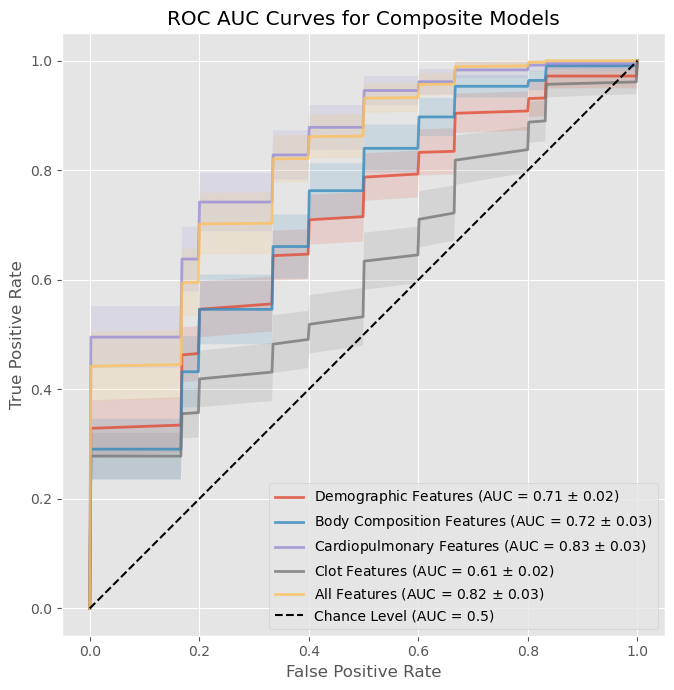

In [125]:
model_names = ['Demographic Features', 'Body Composition Features', 'Cardiopulmonary Features', 'Clot Features', 'All Features']

fig, axs = plt.subplots(figsize=(7, 7))

for i, model_name in enumerate(model_names):
    print(model_name)
    
    feat = model_dfns_remaining[i]
    X_temp = X[feat].reset_index(drop=True)
    y_temp = y.copy().reset_index(drop=True)
    
    # cv = StratifiedKFold(n_splits=CV_FOLDS)
    cv = CUSTOM_CV
    classifier = LogisticRegression(
            random_state=SEED,
            fit_intercept=True,
            max_iter=1_000, 
            penalty=None, 
            solver='newton-cg',
    )
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 500)
    
    for fold, (train, test) in enumerate(cv.split(X_temp, y_temp)):
        try:
            classifier.fit(X_temp.loc[train, :], y[train])
            ffpr, ftpr, fthresh = roc_curve(y_temp[test].squeeze(), classifier.predict_proba(X_temp.loc[test])[:, 1])
            fauc = roc_auc_score(y_temp[test], classifier.predict(X_temp.loc[test, :]))
            interp_tpr = np.interp(mean_fpr, ffpr, ftpr)
            tprs.append(interp_tpr)
            aucs.append(fauc)
        except:
            print(f"Could not fit fold {fold}")
            continue
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_error_auc = np.std(aucs) / np.sqrt(len(aucs))

    n_std_error = 1.96
    
    axs.plot(
        mean_fpr,
        mean_tpr,
        label=f"{model_name} (AUC = {mean_auc:.2f} $\pm$ {n_std_error * std_error_auc:.2f})",
        lw=2,
        alpha=0.8,
    )
    
    std_error_tpr = np.std(tprs, axis=0) / np.sqrt(len(tprs))
    
    tprs_upper = np.minimum(mean_tpr + n_std_error * std_error_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std_error * std_error_tpr, 0)
    axs.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        alpha=0.15,
        # label=f"$\pm$ {n_std_error:.2f} SE",
    )
    
axs.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title='ROC AUC Curves for Composite Models',
)

axs.plot([0, 1], [0, 1], "k--", label="Chance Level (AUC = 0.5)")

axs.axis("square")
axs.legend(loc="lower right", fontsize=10)

plt.tight_layout()

plt.savefig('../figures/roc_curves_2.png')